In [1]:
import os
import re
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils import *

warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# File loading
df = pd.read_excel(r'..\..\Data\Sales.xlsx', 'Sheet1')
df.name = 'Sales'

In [3]:
# Dataframe head
df.head()

,Cal Date,Cust Sold To Nbr,Product 5-digit Code,QTY Pieces,VBR,ISV excl Log Sur,Logistic Surcharge,COS,Dist Costs
0,2017-02-22,28502952,50601M,2000.0,0.0,180.0,0.0,86.64,38.60
1,2017-07-26,28502952,50601M,2000.0,0.0,180.0,0.0,86.64,38.60
2,2017-12-21,28502952,50601M,1000.0,0.0,90.0,0.0,43.32,19.30
3,2018-06-15,28502952,50601M,1500.0,0.0,135.0,0.0,64.98,28.95
4,2017-02-22,28502952,50602M,4000.0,0.0,370.0,0.0,180.88,77.20


In [4]:
# Dataframe shape
df_shape = df.shape
print("This dataframe has %d columns and %d rows." % (df_shape[1], df_shape[0]))

This dataframe has 9 columns and 605487 rows.


In [5]:
mx = max(df['Cal Date'])
mn = min(df['Cal Date'])
delta_date = (mx-mn).days
y = delta_date//365
m = (delta_date-y*365)//30
d = delta_date-y*365-m*30

print('the first sale was done at ', mn)
print('the last sale was done at ', mx)
print('the sales span %d year %d months %d days' % (y,m,d))

the first sale was done at  2017-01-01 00:00:00
the last sale was done at  2018-06-30 00:00:00
the sales span 1 year 6 months 0 days


In [6]:
# Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605487 entries, 0 to 605486
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Cal Date              605487 non-null  datetime64[ns]
 1   Cust Sold To Nbr      605487 non-null  int64         
 2   Product 5-digit Code  605487 non-null  object        
 3   QTY Pieces            605487 non-null  float64       
 4   VBR                   605487 non-null  float64       
 5   ISV excl Log Sur      605487 non-null  float64       
 6   Logistic Surcharge    605487 non-null  float64       
 7   COS                   605487 non-null  float64       
 8   Dist Costs            605487 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 41.6+ MB


In [7]:
df["Cust Sold To Nbr"]=df["Cust Sold To Nbr"].astype(object)

In [8]:
df.describe()

,QTY Pieces,VBR,ISV excl Log Sur,Logistic Surcharge,COS,Dist Costs
count,6.054870e+05,605487.000000,6.054870e+05,605487.000000,605487.000000,605487.000000
mean,1.395991e+03,-8.010553,4.442257e+02,1.798414,237.549062,24.964773
std,2.653016e+04,181.386871,3.433859e+03,36.888962,1275.116648,101.417216
min,-7.200000e+05,-25562.741873,-1.299681e+06,-4396.726150,-104438.440000,-5245.000000
25%,0.000000e+00,-1.270000,0.000000e+00,0.000000,0.000000,0.000000
50%,2.000000e+01,0.000000,9.294000e+01,0.000000,44.550000,5.830000
75%,2.160000e+02,0.000000,3.078000e+02,0.000000,155.960000,20.790000
max,8.000000e+06,32539.411602,1.299681e+06,10209.122676,224682.740000,12178.800000


<Figure size 432x288 with 0 Axes>

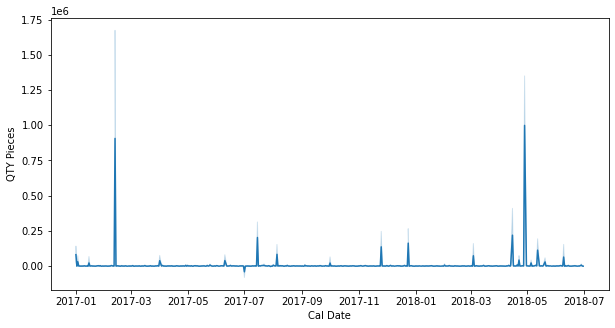

<Figure size 432x288 with 0 Axes>

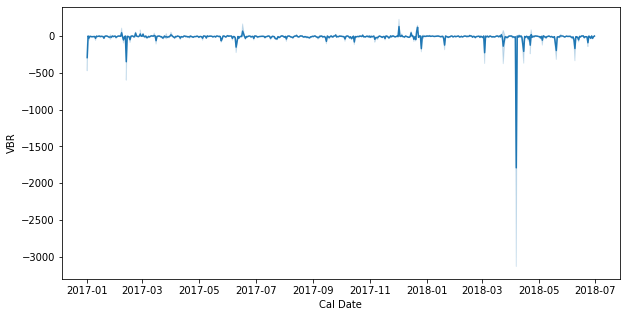

<Figure size 432x288 with 0 Axes>

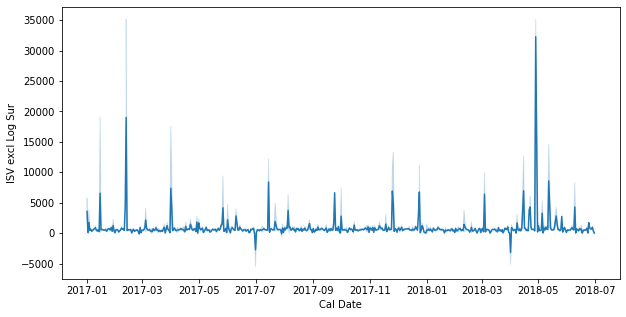

<Figure size 432x288 with 0 Axes>

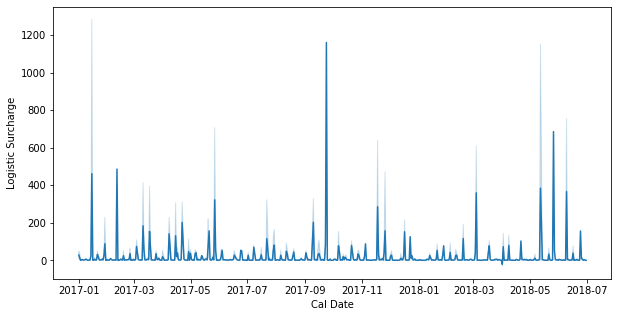

<Figure size 432x288 with 0 Axes>

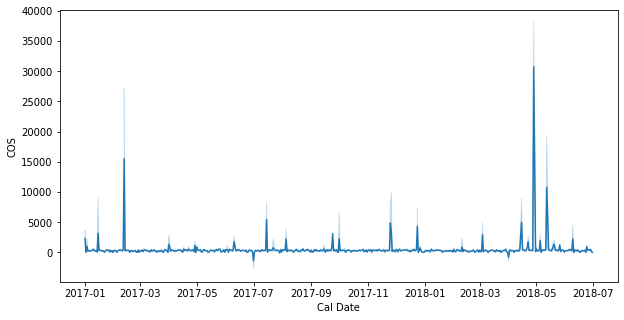

<Figure size 432x288 with 0 Axes>

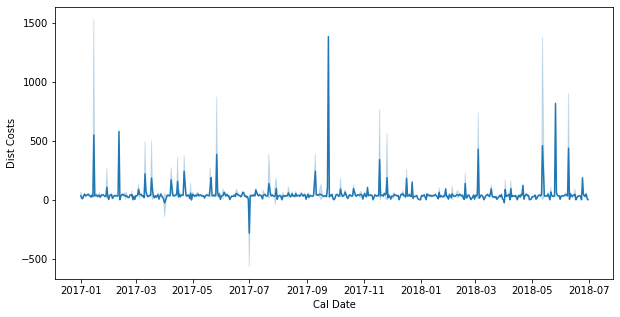

In [9]:
plot_by_date(df, 'Cal Date')

In [10]:
df_sold_not_sample = df.loc[(df['QTY Pieces']!=0)&(df['ISV excl Log Sur']!=0)]

<Figure size 432x288 with 0 Axes>

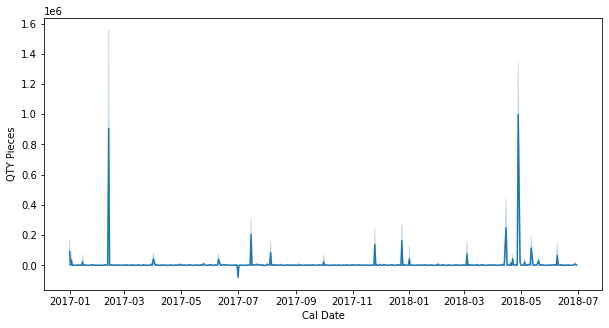

<Figure size 432x288 with 0 Axes>

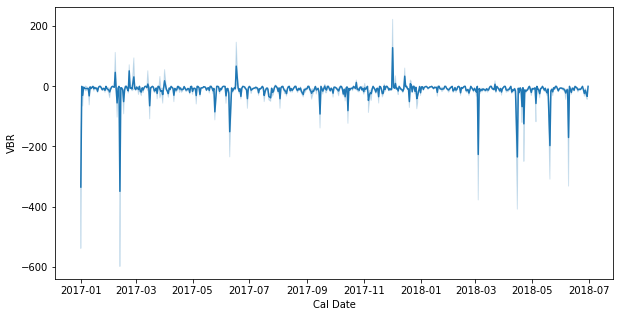

<Figure size 432x288 with 0 Axes>

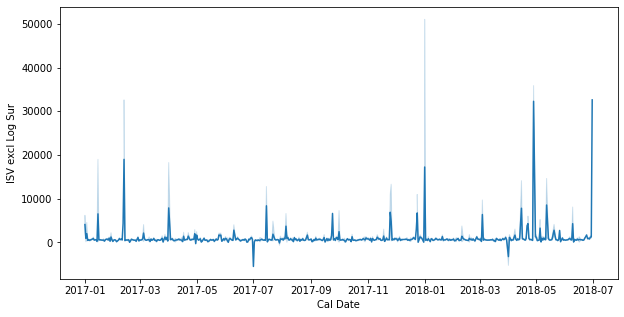

<Figure size 432x288 with 0 Axes>

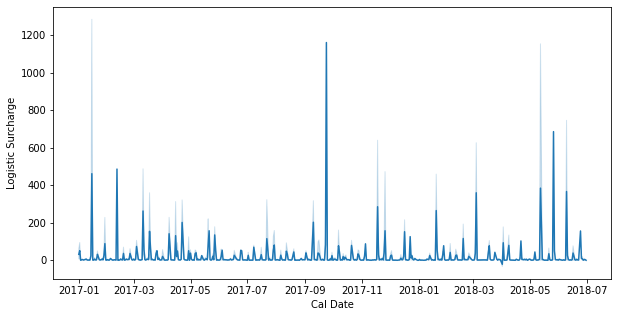

<Figure size 432x288 with 0 Axes>

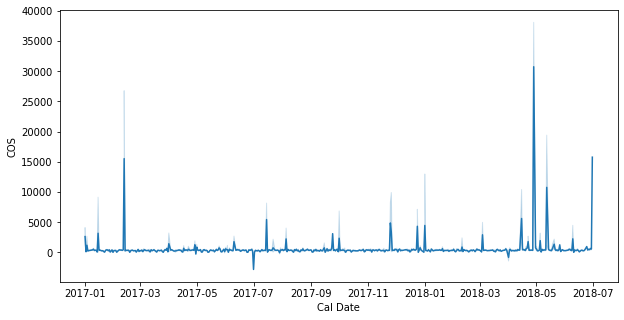

<Figure size 432x288 with 0 Axes>

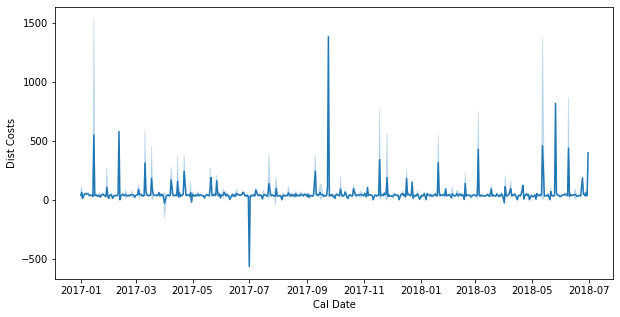

In [11]:
plot_by_date(df_sold_not_sample, 'Cal Date')

In [12]:
df_sold_not_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398922 entries, 0 to 605480
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Cal Date              398922 non-null  datetime64[ns]
 1   Cust Sold To Nbr      398922 non-null  object        
 2   Product 5-digit Code  398922 non-null  object        
 3   QTY Pieces            398922 non-null  float64       
 4   VBR                   398922 non-null  float64       
 5   ISV excl Log Sur      398922 non-null  float64       
 6   Logistic Surcharge    398922 non-null  float64       
 7   COS                   398922 non-null  float64       
 8   Dist Costs            398922 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 30.4+ MB


In [13]:
cols = set(df_sold_not_sample.columns) - set(['Cust Sold To Nbr', 'QTY Pieces'])

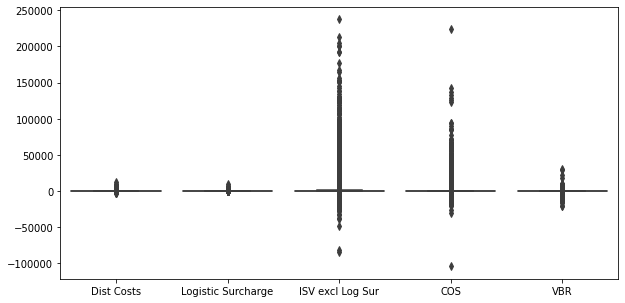

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_sold_not_sample.loc[:, set(df_sold_not_sample.columns) - set(['Cust Sold To Nbr', 'QTY Pieces'])])
plt.show()

<Figure size 432x288 with 0 Axes>

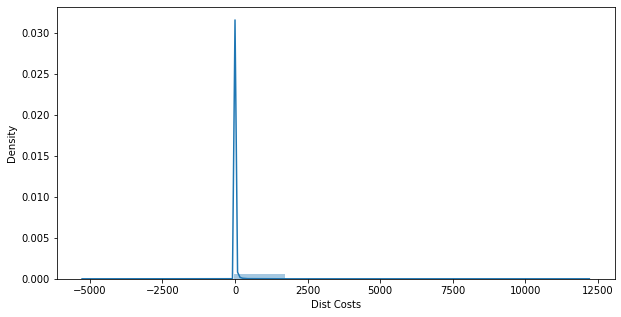

<Figure size 432x288 with 0 Axes>

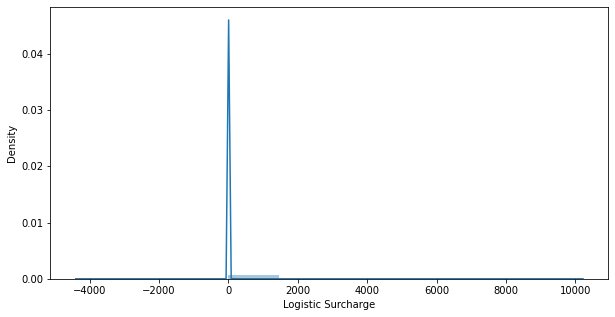

<Figure size 432x288 with 0 Axes>

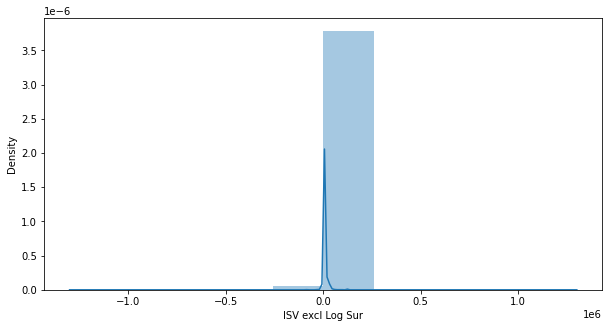

<Figure size 432x288 with 0 Axes>

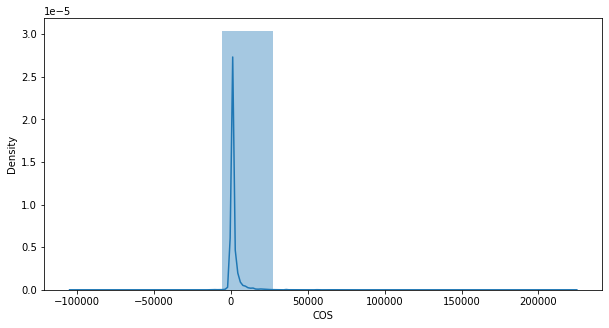

<Figure size 432x288 with 0 Axes>

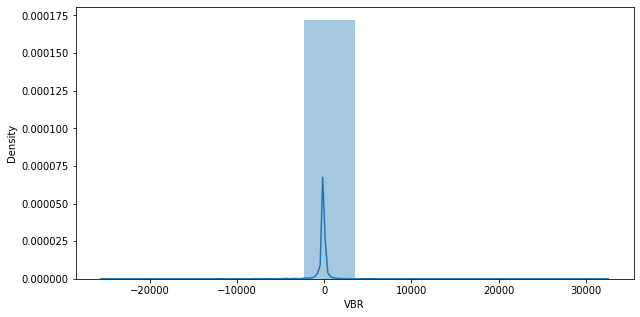

In [15]:
distributions(df.loc[:, cols])

In [16]:
# Categorical features modalities
modalities_table(df)

,Modalities
Product 5-digit Code,4395
Cust Sold To Nbr,4804


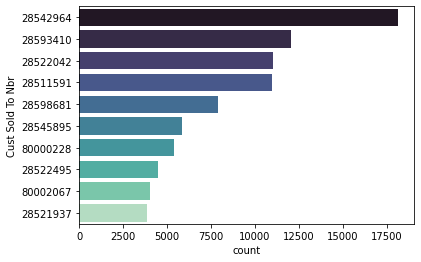

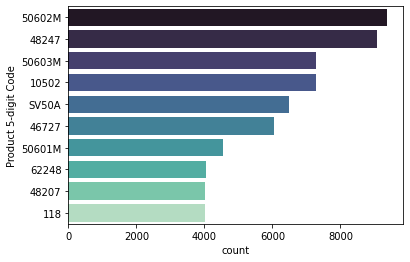

In [17]:
# Distribution of categorical columns        
plot_cat_dist(df)

In [18]:
df[df.eq('-').any(1)]

,Cal Date,Cust Sold To Nbr,Product 5-digit Code,QTY Pieces,VBR,ISV excl Log Sur,Logistic Surcharge,COS,Dist Costs
25705,2017-01-31,28511588,-,0.0,0.0,0.000000,0.0,0.0,0.0
25706,2017-02-28,28511588,-,0.0,0.0,0.000000,0.0,0.0,0.0
25707,2017-03-31,28511588,-,0.0,0.0,0.000000,0.0,0.0,0.0
25708,2017-04-30,28511588,-,0.0,0.0,0.000000,0.0,0.0,0.0
25709,2017-05-31,28511588,-,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
605028,2017-05-15,80274424,-,0.0,0.0,-314.351250,0.0,0.0,0.0
605029,2017-06-23,80274424,-,0.0,0.0,-408.656625,0.0,0.0,0.0
605030,2017-07-14,80274424,-,0.0,0.0,-853.266650,0.0,0.0,0.0
605031,2017-07-20,80274424,-,0.0,0.0,-587.082394,0.0,0.0,0.0


In [19]:
# Replacing missing values with None
df.replace({'-': None},inplace=True)
df[df.isnull().any(axis=1)]

,Cal Date,Cust Sold To Nbr,Product 5-digit Code,QTY Pieces,VBR,ISV excl Log Sur,Logistic Surcharge,COS,Dist Costs
25705,2017-01-31,28511588,None,0.0,0.0,0.000000,0.0,0.0,0.0
25706,2017-02-28,28511588,None,0.0,0.0,0.000000,0.0,0.0,0.0
25707,2017-03-31,28511588,None,0.0,0.0,0.000000,0.0,0.0,0.0
25708,2017-04-30,28511588,None,0.0,0.0,0.000000,0.0,0.0,0.0
25709,2017-05-31,28511588,None,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
605028,2017-05-15,80274424,None,0.0,0.0,-314.351250,0.0,0.0,0.0
605029,2017-06-23,80274424,None,0.0,0.0,-408.656625,0.0,0.0,0.0
605030,2017-07-14,80274424,None,0.0,0.0,-853.266650,0.0,0.0,0.0
605031,2017-07-20,80274424,None,0.0,0.0,-587.082394,0.0,0.0,0.0


In [20]:
print("The number of rows with null values in both columns is %d row" 
      % df[((df.iloc[:,1].isnull())&(df.iloc[:,2].isnull()))].shape[0])

The number of rows with null values in both columns is 0 row


In [21]:
df.iloc[:,2].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
605482    False
605483    False
605484    False
605485    False
605486    False
Name: Product 5-digit Code, Length: 605487, dtype: bool

In [22]:
# Missing value summary
missing_values_table(df)

Your selected dataframe has 9 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Product 5-digit Code,62,0.01


In [23]:
# Missing values export
save_missing_values_table(df, df.name)

In [24]:
# Categorical features modalities
modalities_table(df, True)

,Modalities
Product 5-digit Code,4394


In [25]:
# Net Sales Value and Gross Margin
df['NSV'] = df['ISV excl Log Sur'] + df['VBR'] +  df['Logistic Surcharge']
df['GM'] = df['NSV'] - df['COS'] -  df['Dist Costs']

In [26]:
df_out = df[(np.abs(stats.zscore(df[df.select_dtypes('number').columns])) > 3).all(axis=1)]
df_out

,Cal Date,Cust Sold To Nbr,Product 5-digit Code,QTY Pieces,VBR,ISV excl Log Sur,Logistic Surcharge,COS,Dist Costs,NSV,GM


In [27]:
for c in df.select_dtypes(['float']).columns:
    a = max(df[c].astype(str).str.split('.').str[0].str.len())
    b = max(df[c].astype(str).str.split('.').str[1].str.len())
    print(c+'decimal(%d, %d),' % (a+b, b))

QTY Piecesdecimal(23, 16),
VBRdecimal(24, 18),
ISV excl Log Surdecimal(24, 16),
Logistic Surchargedecimal(22, 17),
COSdecimal(23, 16),
Dist Costsdecimal(22, 17),
NSVdecimal(26, 18),
GMdecimal(28, 20),


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605487 entries, 0 to 605486
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Cal Date              605487 non-null  datetime64[ns]
 1   Cust Sold To Nbr      605487 non-null  int64         
 2   Product 5-digit Code  605425 non-null  object        
 3   QTY Pieces            605487 non-null  float64       
 4   VBR                   605487 non-null  float64       
 5   ISV excl Log Sur      605487 non-null  float64       
 6   Logistic Surcharge    605487 non-null  float64       
 7   COS                   605487 non-null  float64       
 8   Dist Costs            605487 non-null  float64       
 9   NSV                   605487 non-null  float64       
 10  GM                    605487 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 50.8+ MB


## The sale facts should be in this schema :
<br/>
[sale_ID] [int] IDENTITY(1,1) NOT NULL,<br/>
[val_based_rebate] [float] NOT NULL,<br/>
[invoice_sale_val] [float] NOT NULL,<br/>
[logistic_sur] [float] NOT NULL,<br/>
[sale_cost] [float] NOT NULL,<br/>
[dist_cost] [float] NOT NULL,<br/>
[net_sale_revenue] [float] NOT NULL,<br/>
[gross_margin] [float] NOT NULL,<br/>
[customer_ID] [int] NOT NULL,<br/>
[product_ID] [int] NOT NULL,<br/>
[date_ID] [int] NOT NULL,<br/>
[salesrep_ID] [int] NOT NULL